wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jasonlim131 (principle-deep-learning). Use `wandb login --relogin` to force relogin


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/tmp/ipykernel_157809/1300124362.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load("trained_encoder.pth"))
/tmp/ipykernel_157809/130012

Randomly pulled image
Associated label
9
Encoder input shape: torch.Size([1, 3, 32, 32])
Encoder output mu shape: torch.Size([1, 128])
Encoder output logvar shape: torch.Size([1, 128])
Classifier input shape: torch.Size([1, 128])
Classifier output shape: torch.Size([1, 10])
Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])
Predicted label
8
ship


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9259666..2.0591094].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..1.5510519].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3770088..1.773327].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9577202..1.7399687].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8836575..1.9320949].


Encoder input shape: torch.Size([1, 3, 32, 32])
Encoder output mu shape: torch.Size([1, 128])
Encoder output logvar shape: torch.Size([1, 128])
Classifier input shape: torch.Size([1, 128])
Classifier output shape: torch.Size([1, 10])
Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])
Encoder input shape: torch.Size([1, 3, 32, 32])
Encoder output mu shape: torch.Size([1, 128])
Encoder output logvar shape: torch.Size([1, 128])
Classifier input shape: torch.Size([1, 128])
Classifier output shape: torch.Size([1, 10])
Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])
Encoder input shape: torch.Size([1, 3, 32, 32])
Encoder output mu shape: torch.Size([1, 128])
Encoder output logvar shape: torch.Size([1, 128])
Classifier input shape: torch.Size([1, 128])
Classifier output shape: torch.Size([1, 10])
Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])
Encoder input shape: torc

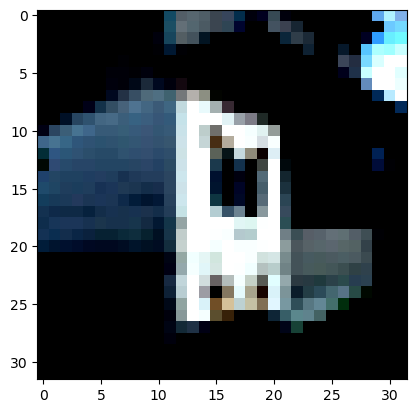

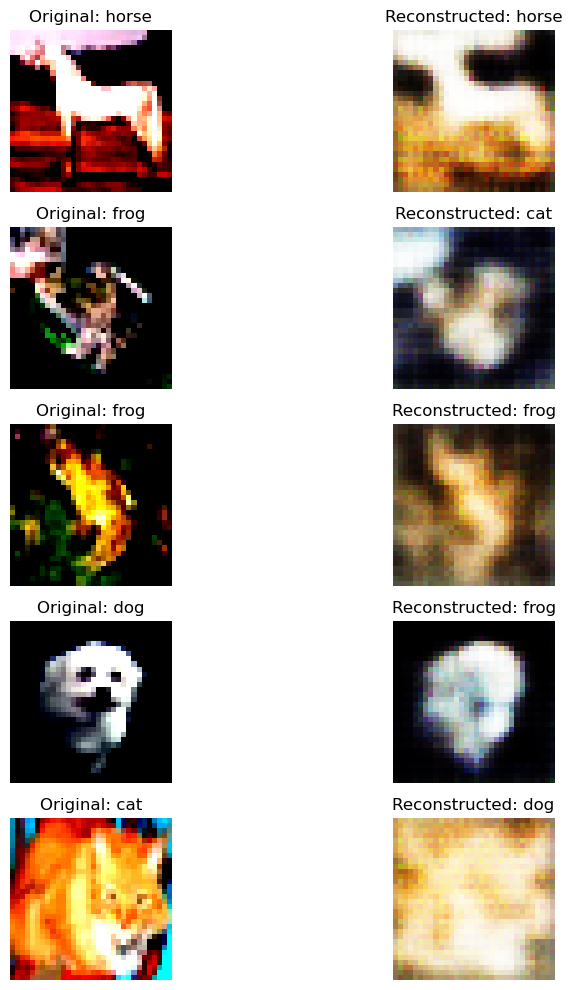

In [1]:
from conv_CBilA import BilinearCNN, Bilinear
from einops import *
import torch
import torch.nn as nn
from decompositions import decompose_bilinear_layer
import torch
from torch import nn, Tensor
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from pathlib import Path
import wandb
from datetime import datetime
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
import numpy as np
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt
from BilinearVAE import BilinearVAE, Encoder, Decoder, Classifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2470, 0.2435, 0.2616)

# autoaugment
transform = transforms.Compose([
transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
transforms.ToTensor(),
transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
])
# Other augmentations I could try:
#Augmix
#Kernel Filtering
#Discrete Cosine Transform
# transform = transforms.Compose([
#     transforms.RandomResizedCrop(32),
#     AugMix(severity=3, width=3, depth=2, alpha=1.),
#     KernelFilter(kernel_size=3),
#     DCTAugmentation(factor=0.1),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

full_train_dataset = datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
    ])
)

train_loader = DataLoader(
       full_train_dataset,
       batch_size=128,
       shuffle=True,
       num_workers=4,
       pin_memory=True
   )
   
test_loader = DataLoader(
       test_dataset,
       batch_size=128, 
       shuffle=False,
       num_workers=4,
       pin_memory=True
   )

import os
os.chdir('/home/ec2-user/repos/tmp/dl-proj')

encoder = Encoder(in_channels=3, base_channels=64)
classifier = Classifier(hidden_dim=128, num_classes=10, gate=None)
decoder = Decoder(latent_dim=128)
encoder.load_state_dict(torch.load("trained_encoder.pth"))
classifier.load_state_dict(torch.load("trained_classifier.pth"))
decoder.load_state_dict(torch.load("trained_decoder.pth"))

vae = BilinearVAE(encoder, classifier, decoder, num_samples=5).to(device)
vae.load_state_dict(torch.load("trained_vae.pth"))

vae.eval()

encoder = vae.encoder
decoder = vae.decoder
classifier = vae.classifier

# Load random image from dataset
random_index = np.random.randint(0, len(test_dataset))
random_image = test_dataset[random_index][0]
random_label = test_dataset[random_index][1]

print("Randomly pulled image")
plt.imshow(random_image.permute(1, 2, 0))

cifar10_label_dict = {}
print("Associated label")
print(random_label)

random_image = random_image.to(device).unsqueeze(0)
encoded_mu, encoded_var = encoder(random_image)
z = vae.reparameterize(encoded_mu, encoded_var)[0]
predicted_logits = classifier(z)
predicted_label = torch.argmax(predicted_logits, dim=1).cpu().detach().item()
reconstructed_image = decoder(z).cpu().detach()

label_names = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
print("Predicted label")
print(predicted_label)
print(label_names[predicted_label])

num_images = 5
fig, axes = plt.subplots(num_images, 2, figsize=(10, 2 * num_images))
    
for i in range(num_images):
    # Select a random image from the dataset
    random_index = np.random.randint(0, len(test_dataset))
    random_image, random_label = test_dataset[random_index]
    
    # Display original image
    axes[i, 0].imshow(random_image.permute(1, 2, 0).cpu().numpy())
    axes[i, 0].set_title(f"Original: {label_names[random_label]}")
    axes[i, 0].axis("off")
    
    # Process the image through the VAE
    random_image = random_image.to(device).unsqueeze(0)  # Add batch dimension
    encoded_mu, encoded_var = encoder(random_image)
    z = vae.reparameterize(encoded_mu, encoded_var)[0]
    predicted_logits = classifier(z)
    predicted_label = torch.argmax(predicted_logits, dim=1).cpu().detach().item()
    reconstructed_image = decoder(z).cpu().detach().squeeze(0)  # Remove batch dimension
    
    # Display reconstructed image
    axes[i, 1].imshow((reconstructed_image.permute(1, 2, 0) + 1) / 2)  # Scale to [0, 1]
    axes[i, 1].set_title(f"Reconstructed: {label_names[predicted_label]}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()



In [2]:
#label_names = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
#print("Predicted label")
#print(predicted_label)
#print(label_names[predicted_label])

In [3]:
#print("Reconstructed image")
#plt.imshow(reconstructed_image.squeeze(0).permute(1, 2, 0))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.34358257..0.3679913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.30741903..0.22044854].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.35842824..0.3400291].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3190747..0.340502].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.34451142..0.28259194].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.36437768..0.189492].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3

Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])
Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])
Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])
Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])
Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])
Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])
Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])
Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])
Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])
Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])
Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.27011597..0.12505509].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39131704..0.27050215].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3230786..0.21682516].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.30088404..0.18165746].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38253307..0.21186733].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39300928..0.24823967].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range

Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])
Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])
Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])
Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])
Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])
Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])
Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])
Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])
Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])
Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])
Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])

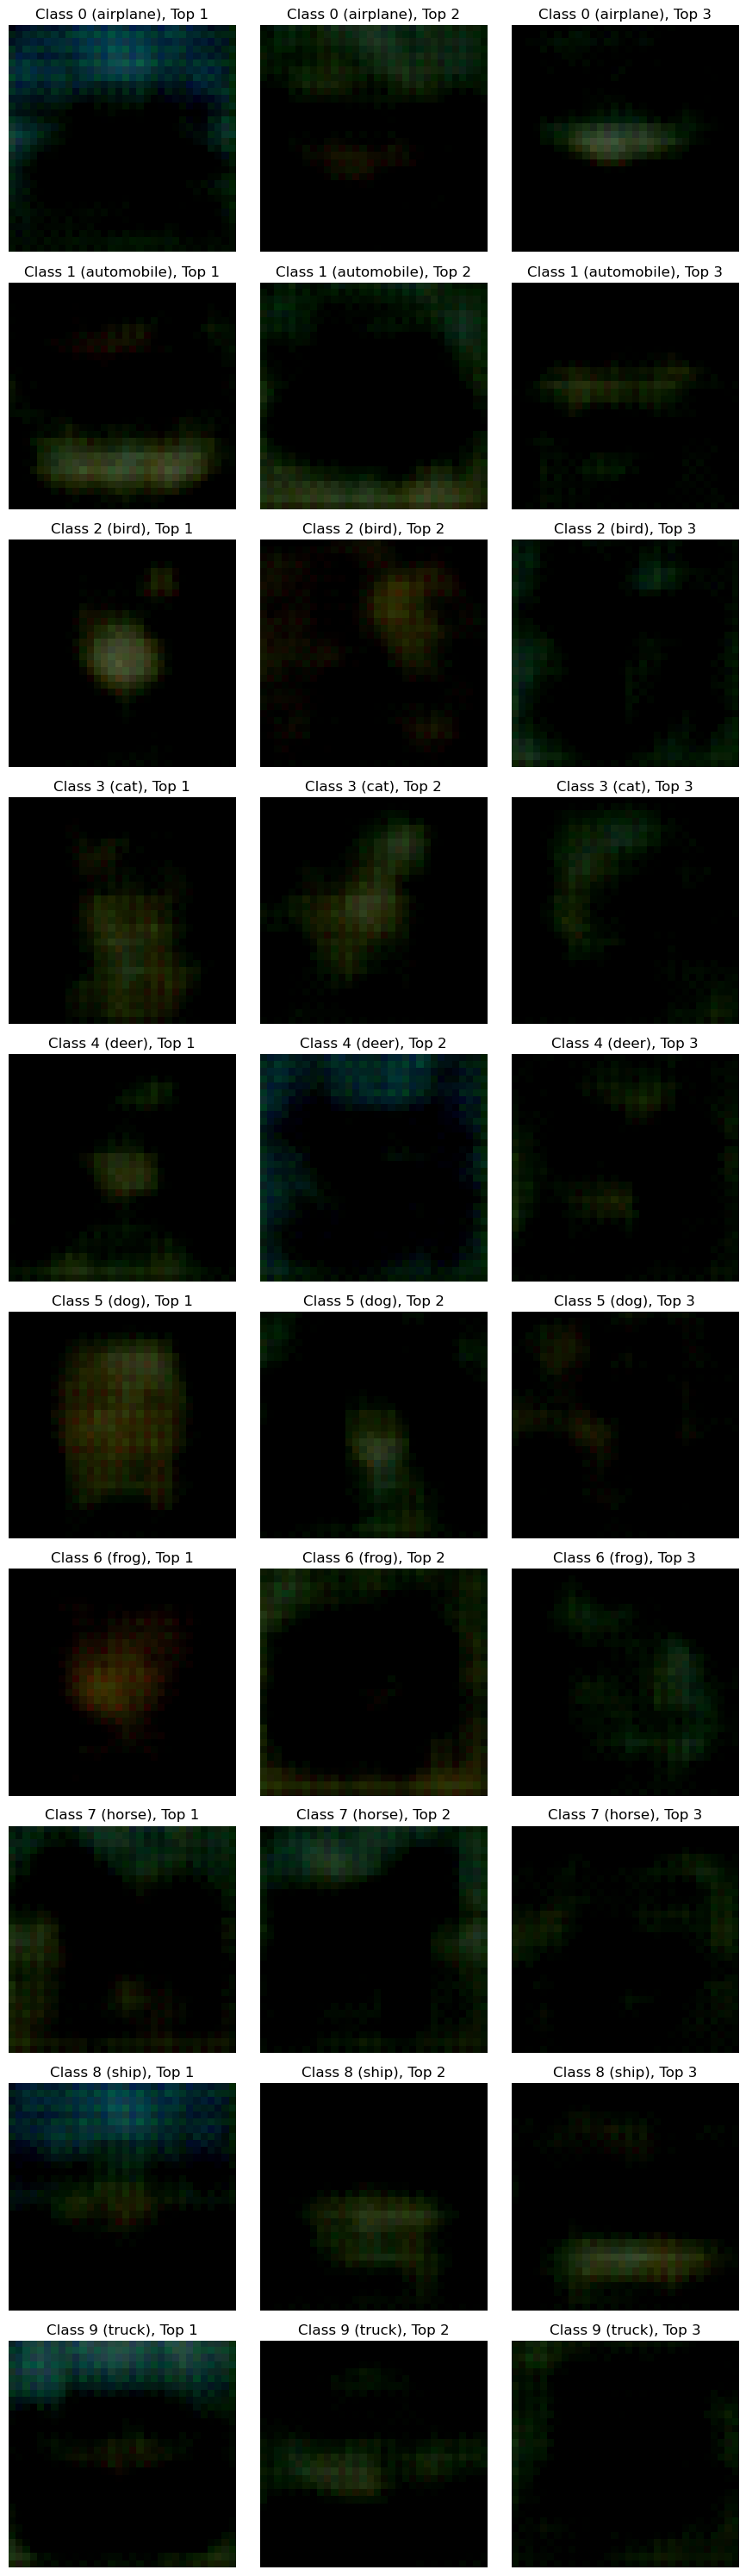

In [21]:
from decompositions import decompose_bilinear_layer
eigenvals, eigenvecs = decompose_bilinear_layer(classifier.fc1, classifier.bilinear, classifier.fc2)
eigenvals = eigenvals.cpu().detach()
eigenvecs = eigenvecs.cpu().detach()
feature_map = eigenvecs[0, -1].view(1, 128).to(device)
decoded_image = decoder(feature_map)
decoded_image = decoded_image.cpu().detach()

fig, axes = plt.subplots(10, 3, figsize=(9, 30))  # Create a grid of 10x3 subplots

for i in range(10): # loop over classes (?)
    for j in range(3):
        feature_map = eigenvecs[i, -1 * (j + 1)].view(1, 128).to(device)
        decoded_image = decoder(feature_map)
        decoded_image = decoded_image.cpu().detach()
        ax = axes[i, j]
        ax.imshow(decoded_image.squeeze(0).permute(1, 2, 0).numpy())
        ax.set_title(f"Class {i} ({label_names[i]}), Top {j+1}")
        ax.axis("off")

## Add title to the figure
#fig.suptitle("Decoded Eigenvectors from Bilinear Decomposition", fontsize=16)
plt.tight_layout()
plt.show()


# for i in range(9):
#     this_class_eigenvals = eigenvals[i]
#     this_class_eigenvecs = eigenvecs[i]
#     sorted_indices = torch.argsort(this_class_eigenvals, descending=True, dim=0)  # Descending order
#     print(f"sorted_indices: {sorted_indices}")
#     print(f"this_class_eigenvals shape: {this_class_eigenvals.shape}")
#     print(f"this_class_eigenvecs shape: {this_class_eigenvecs.shape}")

#     sorted_eigenvals = this_class_eigenvals
#     num_vectors = sorted_eigenvals.size(0)
#     print(f"num_vectors: {num_vectors}")
#     sorted_eigenvecs = eigenvecs[:, sorted_indices]
    
# print("=============")
# fig, axes = plt.subplots(1, num_vectors, figsize=(4 * num_vectors, 4))  # Adjust size as needed
    
# for i in range(num_vectors):
#     eigenvector_image = sorted_vecs[i].cpu()
#     eigenvalue = sorted_vals[i].cpu()
#     # Plot the eigenvector
#     ax = axes[i] if num_vectors > 1 else axes  # Handle single subplot case
#     im = ax.imshow(eigenvector_image)
#     ax.set_title(f"Eigenvalue: {sorted_vals[i]:.2f}", fontsize=10)
#     ax.axis('off')

# plt.tight_layout()
# plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6515267..0.78236836].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.74429715..0.78328645].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6536031..0.679377].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7957761..0.8328239].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.810863..0.5741052].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.75298136..0.58675325].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.764

Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])
Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])
Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])
Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])
Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])
Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])
Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])
Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])
Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])
Decoder input shape: torch.Size([1, 128])
Decoder output shape: torch.Size([1, 3, 32, 32])


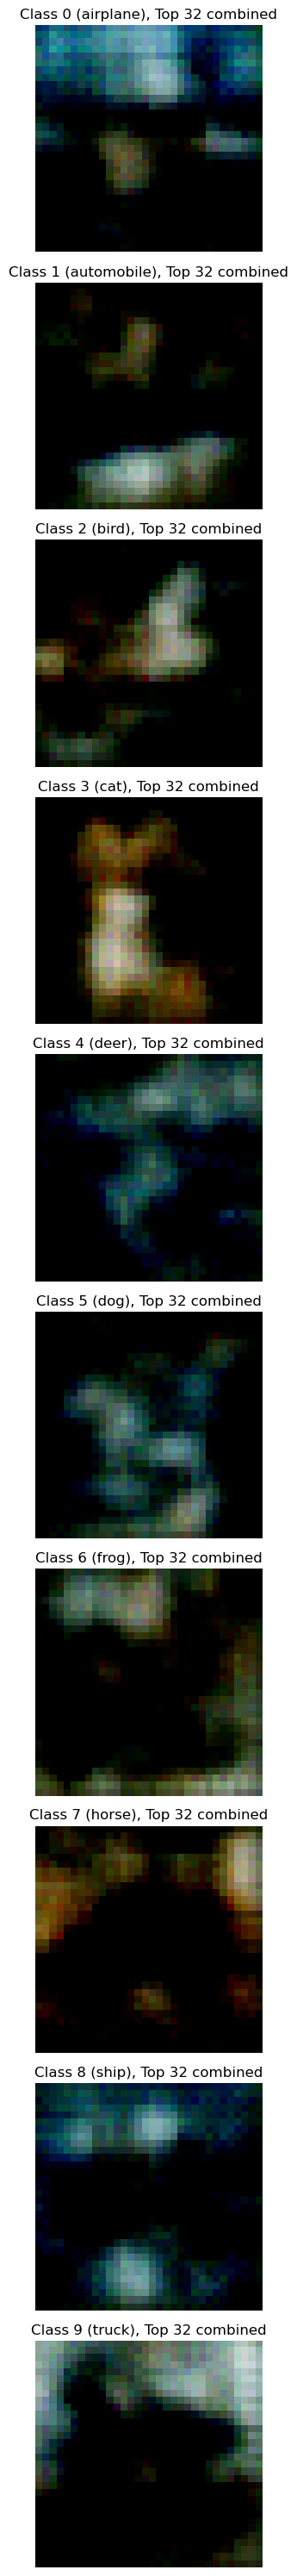

In [27]:
fig, axes = plt.subplots(10, 1, figsize=(9, 30))  # Create a grid of 10 subplots

for i in range(10): # loop over classes 
    total_map = torch.zeros(1, 128).to(device)
    for j in range(32):
        feature_map = eigenvecs[i, -1 * (j + 1)].view(1, 128).to(device)
        total_map += feature_map
    decoded_image = decoder(total_map)
    decoded_image = decoded_image.cpu().detach()
    ax = axes[i]
    ax.imshow(decoded_image.squeeze(0).permute(1, 2, 0).numpy())
    ax.set_title(f"Class {i} ({label_names[i]}), Top 32 combined")
    ax.axis("off")

## Add title to the figure
#fig.suptitle("Decoded Eigenvectors from Bilinear Decomposition", fontsize=16)
plt.tight_layout()
plt.show()

In [33]:
## This cell largely adapted from the code at https://github.com/tdooms/bilinear-decomposition/blob/main/image/plotting.py

from plotly.subplots import make_subplots
from jaxtyping import Float
from torch import Tensor
from einops import *
import plotly.graph_objects as go
import plotly.express as px
import torch

def plot_explanation(vae, sample: Float[Tensor, "w h"], eigenvalues=10):
    """Creates a plot showing the top eigenvector activations for a given input sample."""
    colors = px.colors.qualitative.Plotly
    
    #logits = model(sample)[0].cpu()
    encoded_mu, encoded_var = vae.encoder(sample)
    z = vae.reparameterize(encoded_mu, encoded_var)[0]
    logits = vae.classifier(z)
    
    classes = logits.topk(3).indices.sort().values.cpu()
    
    # compute the activations of the eigenvectors for a given sample
    vals, vecs = decompose_bilinear_layer(vae.classifier.fc1, vae.classifier.bilinear, vae.classifier.fc2)
    vals, vecs = vals.cpu(), vecs.cpu()
    acts = einsum(sample.flatten().cpu(), vecs, "inp, cls comp inp -> cls comp").pow(2) * vals

    # compute the contributions of the top 3 classes
    contrib, idxs = acts[classes].sort(dim=-1)

    titles = [''] + [f"{c}" for c in classes] + ['input', ''] + [f"{c}" for c in classes] + ['logits']
    fig = make_subplots(rows=2, cols=5, subplot_titles=titles, vertical_spacing=0.1)
    fig.update_xaxes(visible=False).update_yaxes(visible=False)
    
    # add line plot for eigenvalues
    for i in range(3):
        params = dict(showlegend=False, marker=dict(color=colors[i]))
        fig.add_scatter(y=contrib[i, -eigenvalues-2:].flip(0), mode="lines", **params, row=1, col=1)
        fig.add_scatter(y=contrib[i, -1:].flip(0), mode="markers", **params, row=1, col=1)
        
        fig.add_scatter(y=contrib[i, :eigenvalues+2], mode="lines", **params, row=2, col=1)
        fig.add_scatter(y=contrib[i, :1], mode="markers", **params, row=2, col=1)
    
    # add heatmaps for the top 3 classes
    for i in range(3):
        params = dict(showscale=False, colorscale="RdBu", zmid=0)
        fig.add_heatmap(z=vecs[classes[i]][idxs[i, -1]].view(32, 32).flip(0), **params, row=1, col=i+2)
        fig.add_heatmap(z=vecs[classes[i]][idxs[i, 0]].view(32, 32).flip(0), **params, row=2, col=i+2)
    
    # add tickmarks for the heatmaps
    for i in range(2):
        tickvals = [0] + list(contrib[:3, [-1, 0][i]])
        ticktext = [f'{val:.2f}' for val in tickvals]
        fig.update_yaxes(visible=True, tickvals=tickvals, ticktext=ticktext, col=1, row=i+1)
    
    bars, text = ["gray"] * 10, [""] * 10
    for i, c in zip(classes, colors):
        bars[i], text[i] = c, f"{i}"

    fig.add_bar(y=logits, marker_color=bars, text=text, showlegend=False, textposition='outside', textfont=dict(size=12), row=2, col=5)
    fig.update_yaxes(range=[logits.min(), logits.max() * 1.5], row=2, col=5)
    
    fig.add_heatmap(z=sample[0].flip(0).cpu(), colorscale="RdBu", zmid=0, showscale=False, row=1, col=5)
    fig.update_annotations(font_size=13)
    
    fig.update_xaxes(visible=True, tickvals=[eigenvalues], ticktext=[f'{eigenvalues}'], zeroline=False, col=1)
    fig.update_layout(width=800, height=320, margin=dict(l=0, r=0, b=0, t=20), template="plotly_white")

    return fig


def plot_eigenspectrum(vae, label_id, eigenvectors=3, eigenvalues=20, ignore_pos=[], ignore_neg=[]):
    """Plot the eigenspectrum for a given label_id."""
    colors = px.colors.qualitative.Plotly
    fig = make_subplots(rows=2, cols=1 + eigenvectors)
    
    vals, vecs = decompose_bilinear_layer(vae.classifier.fc1, vae.classifier.bilinear, vae.classifier.fc2)
    vals, vecs = vals[label_id].cpu().detach(), vecs[label_id].cpu().detach()
    
    negative = torch.arange(eigenvectors)
    positive = -1 - negative

    fig.add_trace(go.Scatter(y=vals[-eigenvalues-2:].flip(0), mode="lines"), row=1, col=1)
    fig.add_trace(go.Scatter(x=negative.flip(0), y=vals[positive].flip(0), mode='markers', marker=dict(color=colors[0])), row=1, col=1)

    fig.add_trace(go.Scatter(y=vals[:eigenvalues+2], mode="lines", marker=dict(color=colors[1])), row=2, col=1)
    fig.add_trace(go.Scatter(x=negative, y=vals[negative], mode='markers', marker=dict(color=colors[1])), row=2, col=1)

    for i, idx in enumerate(positive):
        fig.add_trace(go.Heatmap(z=vecs[idx].view(16, 16).flip(0), colorscale="RdBu", zmid=0, showscale=False), row=1, col=i+2)

    for i, idx in enumerate(negative):
        fig.add_trace(go.Heatmap(z=vecs[idx].view(16, 16).flip(0), colorscale="RdBu", zmid=0, showscale=False), row=2, col=i+2)

    fig.update_xaxes(visible=False).update_yaxes(visible=False)
    fig.update_xaxes(visible=True, tickvals=[eigenvalues], ticktext=[f'{eigenvalues}'], zeroline=False, col=1)
    fig.update_yaxes(zeroline=True, rangemode="tozero", col=1)
    
    tickvals = [0] + [x.item() for i, x in enumerate(vals[positive]) if i not in ignore_pos]
    ticktext = [f'{val:.2f}' for val in tickvals]
    
    fig.update_yaxes(visible=True, tickvals=tickvals, ticktext=ticktext, col=1, row=1)

    tickvals = [0] + [x.item() for i, x in enumerate(vals[negative]) if i not in ignore_neg]
    ticktext = [f'{val:.2f}' for val in tickvals]
    fig.update_yaxes(visible=True, tickvals=tickvals, ticktext=ticktext, col=1, row=2)

    fig.update_coloraxes(showscale=False)
    fig.update_layout(autosize=False, width=170*(eigenvectors+1), height=300, margin=dict(l=0, r=0, b=0, t=0), template="plotly_white")
    fig.update_legends(visible=False)
    
    return fig
## label_names = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

plot_eigenspectrum(vae, label_id=0)

RuntimeError: shape '[16, 16]' is invalid for input of size 128

In [ ]:
plot_eigenspectrum(vae, label=5)

In [ ]:
plot_eigenspectrum(vae, label=8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7989522..1.3812813].


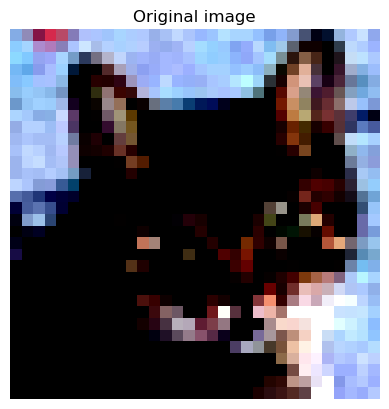

Encoder input shape: torch.Size([1, 3, 32, 32])
Encoder output mu shape: torch.Size([1, 128])
Encoder output logvar shape: torch.Size([1, 128])
Classifier input shape: torch.Size([1, 128])
Classifier output shape: torch.Size([1, 10])


RuntimeError: einsum(): subscript a has size 128 for operand 1 which does not broadcast with previously seen size 3072

In [36]:
# Select a random image from the dataset
random_index = np.random.randint(0, len(test_dataset))
random_image, random_label = test_dataset[random_index]
    
# Display original image
fig, ax = plt.subplots()
ax.imshow(random_image.permute(1, 2, 0).cpu().numpy())
ax.set_title(f"Original: {label_names[random_label]}")
ax.axis("off")
plt.title("Original image")
plt.show()

# Process the image through the VAE
random_image = random_image.to(device).unsqueeze(0)  # Add batch dimension
plot_explanation(vae, random_image, eigenvalues=10)